In [ ]:
%reload_ext autoreload 
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"

In [ ]:
import jax
import jax.numpy as jnp
import hamux as hmx
import treex as tx
from flax import linen as nn # For initializers
import optax
import jax.tree_util as jtu
from typing import *
import matplotlib.pyplot as plt
from dataclasses import dataclass
from loguru import logger
from einops import rearrange
from tqdm.auto import trange, tqdm
from pathlib import Path
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.colors as colors
plt.set_cmap('bwr') # a good start: blue to white to red colormap

<Figure size 800x800 with 0 Axes>

In [ ]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [ ]:
def summarize_mnist_weights(ham, kh=32, kw=32, fig=None):
    # W2 = np.random.normal(size=(10,1024))
    norm = colors.TwoSlopeNorm(vcenter=0)

    Wimg = ham.synapses[0].W1
    Wlabel = ham.synapses[0].W2
    
    nWimg = jnp.sqrt(jnp.power(Wimg,2).sum(-2, keepdims=True))
    nWlabel = jnp.sqrt(jnp.power(Wlabel,2).sum(-2, keepdims=True))
    
    Wimg = Wimg / nWimg
    Wlabel = Wlabel / nWlabel
    
    # imgs_big = rearrange(np.repeat(imgs, 11, axis=0)[:1024], "... h w -> ... (h w)")[:,0].T
    Wimg_show = rearrange(Wimg, "(h w) (kh kw) -> (kh h) (kw w)", h=28, w=28, kh=kh, kw=kw)
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, figsize=(12,6), width_ratios=(2,5))
    else:
        axs = fig.subplots(1, 2, width_ratios=(2,5))
    def prep_axis(ax):
        ax.axis('off')
    [prep_axis(ax) for ax in axs]

    pos0 = axs[0].imshow(Wlabel.T[:20], aspect="auto", interpolation="nearest")
    # fig.colorbar(pos0, ax=axs[0], location="right", shrink=0.7)
    axs[0].set_title("Label matrix")

    pos1 = axs[1].imshow(Wimg_show, norm=norm)
    axs[1].set_title("pixel_matrix")
    fig.colorbar(pos1, ax=axs[1], location="right", shrink=0.7)


#     axs[2].set_title("activations")
#     pos2 = axs[2].imshow(W2[:1].T, aspect="auto", interpolation="nearest")
#     fig.colorbar(pos2, ax=axs[2], location="right")
    return fig

<matplotlib.image.AxesImage>

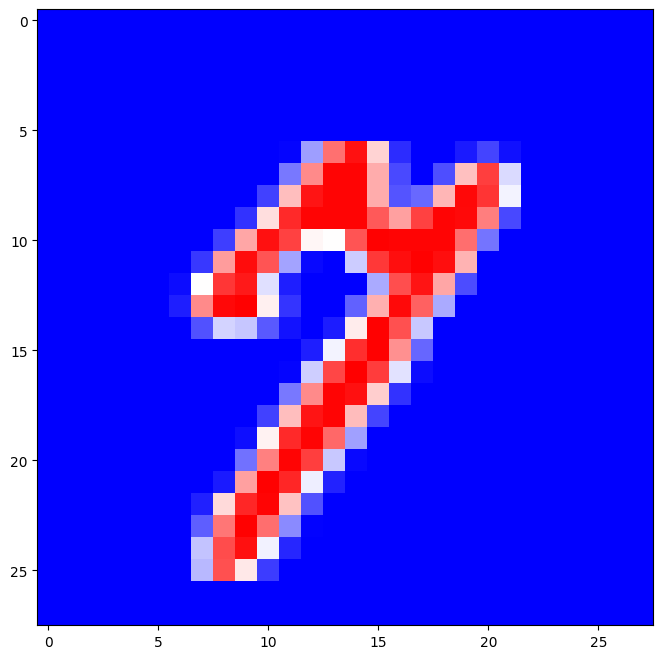

In [ ]:
from hamux.datasets import *

dl_args = DataloadingArgs(
    dataset="torch/MNIST",
    # aa="rand",
    aa=None,
    reprob=0.,
    vflip=0.0,
    hflip=0.0,
    scale=(0.9, 1.1),
    batch_size=100,
    color_jitter=0.0,
    validation_batch_size=1000,
)
data_config = DataConfigMNIST(input_size=(1, 28, 28), mean=0.5, std=0.5)

train_dl, eval_dl = create_dataloaders(dl_args, data_config)

for batch in train_dl:
    imgs, labels = batch
    break
    
plt.imshow(data_config.show(imgs[2]))

In [ ]:
def normal_init(std=1.0, mean=0.0):
    def _f(key, shape, dtype=jnp.float64):
        return (jax.random.normal(key, shape, dtype=dtype) * std) + mean
    return _f

class HopfieldNetworkAsSynapse(hmx.Synapse):
    """A simple reimplementation of a Hopfield Network as a synapse, returning the alignment"""
    W1: jnp.ndarray = tx.Parameter.node() # treex's preferred way of declaring an attribute as a parameter
    W2: jnp.ndarray = tx.Parameter.node()
    nhid: int
    beta: float = tx.Parameter.node()
    
    def __init__(self, nhid:int, beta_init=0.1):
        self.nhid = nhid
        self.beta = beta_init
    
    def __call__(self, g1, g2):
        """The alignment function, defined on an unbatched `g`"""
        if self.initializing():
            self.W1 = normal_init(mean=0.0, std=0.01)(tx.next_key(), g1.shape + (self.nhid,))
            self.W2 = normal_init(std=0.01)(tx.next_key(), g2.shape + (self.nhid,))
        # hidsig = g1 @ self.W1 + g2 @ self.W2
        # hidsig = - jnp.abs(self.W1 - g1[:,None]).sum(-2) - jnp.abs(self.W2 - g2[:,None]).sum(-2)
        # hidsig = - jnp.pow(jnp.abs(self.W1 - g1[:,None]),2).sum(-2) - jnp.pow(jnp.abs(self.W2 - g2[:,None]),2).sum(-2)

        # nW1 = jnp.abs(self.W1).sum(-2, keepdims=True)
        # nW2 = jnp.abs(self.W2).sum(-2, keepdims=True)
        nW1 = jnp.sqrt(jnp.power(self.W1,2).sum(-2, keepdims=True))
        nW2 = jnp.sqrt(jnp.power(self.W2,2).sum(-2, keepdims=True))
        
        hidsig = g1 @ (self.W1 / nW1) + g2 @ (self.W2 / nW2)

        # hid_lagrangian_value = 1/self.beta * jax.nn.logsumexp(self.beta * hidsig, axis=-1)
        hid_lagrangian_value = (1/self.beta * jnp.exp(self.beta * hidsig)).sum(-1)
        return hid_lagrangian_value
    
ImageLayer = hmx.Layer(hmx.lagrangians.LSphericalNorm(), (28*28,))
# ImageLayer = hmx.Layer(hmx.lagrangians.LTanh(beta=0.5), (28*28,))
LabelLayer = hmx.Layer(hmx.lagrangians.LSoftmax(beta=0.005), (10,))

layers = [ImageLayer, LabelLayer]
synapses = [HopfieldNetworkAsSynapse(nhid=32**2, beta_init=7.)]
connections = [((0,1),0)]
ham = hmx.HAM(layers, synapses, connections)

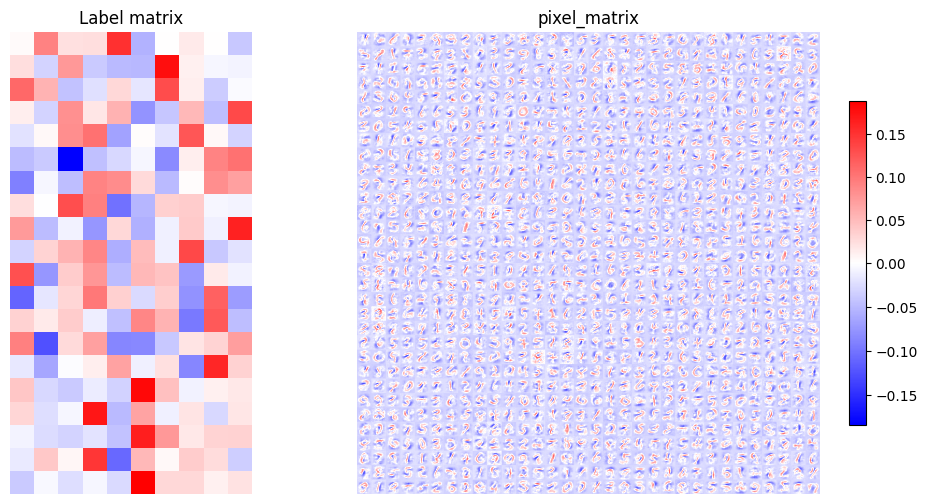

In [ ]:
model_fname = "_logs/DummyMNIST_epoch-67_acc-97.890.pckl"
loaded_model = hmx.HAM.load_ckpt(ham, model_fname)
summarize_mnist_weights(loaded_model);

In [ ]:
def fwd_energy(model, x, depth=4, dt=0.4, rng=None):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(x.shape[0], rng=rng)
    xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # Masks allow us to clamp our visible data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)
    
    # if clamp_label is not None:
    #     xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1.)
    #     print(xs[-1])
    #     masks[-1] = jnp.zeros_like(masks[-1])

    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
    all_xs = [xs]
    energies = [model.venergy(xs)]

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states
        all_xs.append(xs)
        energies.append(model.venergy(xs))

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return jnp.stack(energies), all_xs

In [ ]:
img_start = batch[0][:1]
# img_start = jnp.ones_like(jnp.array(img_start))
energies, allxs = fwd_energy(loaded_model, img_start, dt=0.01, depth=30)

[<matplotlib.lines.Line2D>]

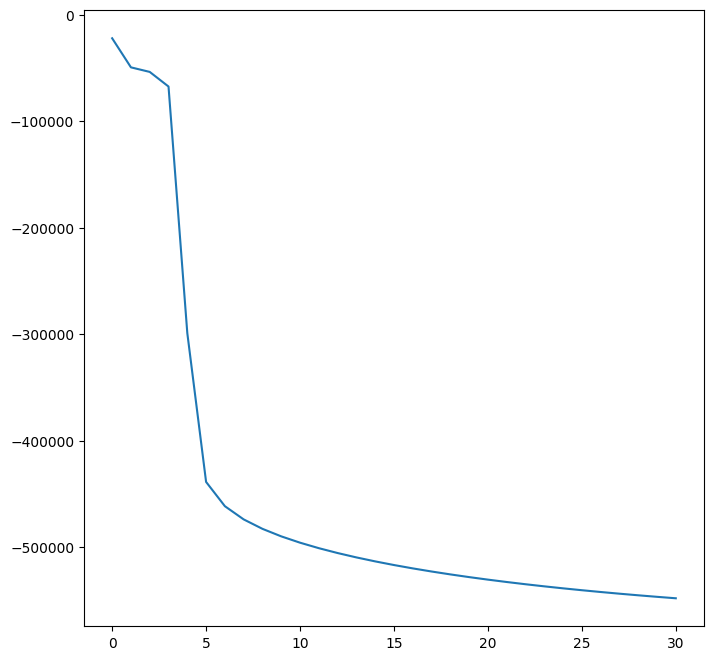

In [ ]:
plt.plot(energies)

<matplotlib.image.AxesImage>

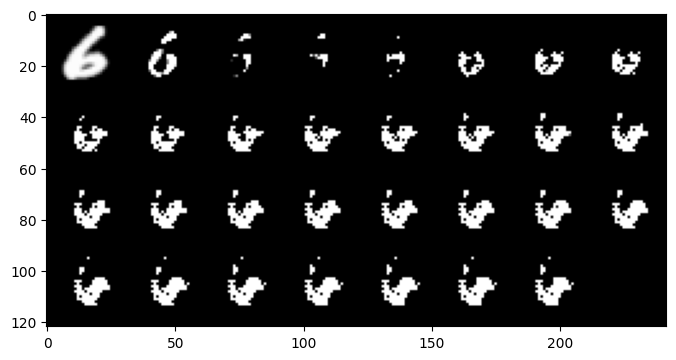

In [ ]:
from torchvision.utils import make_grid

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
    return data_config.show(torch.tensor(np.array(x)))

aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))

In [ ]:
def fwd_energy(model, clamp_label:int, depth=4, dt=0.4, rng=None):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(1, rng=rng)
    # xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # Masks allow us to clamp our label data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)

    xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1050.)
    # xs[-1] = xs[-1].at[...,1].set(1000.)
    print(xs[-1])
    masks[-1] = jnp.zeros_like(masks[-1])

    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
    all_xs = [xs]
    energies = [model.venergy(xs)]

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states
        all_xs.append(xs)
        energies.append(model.venergy(xs))

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return jnp.stack(energies), all_xs

Starting 0
Traced<ShapedArray(float32[1,10])>with<DynamicJaxprTrace(level=0/1)>


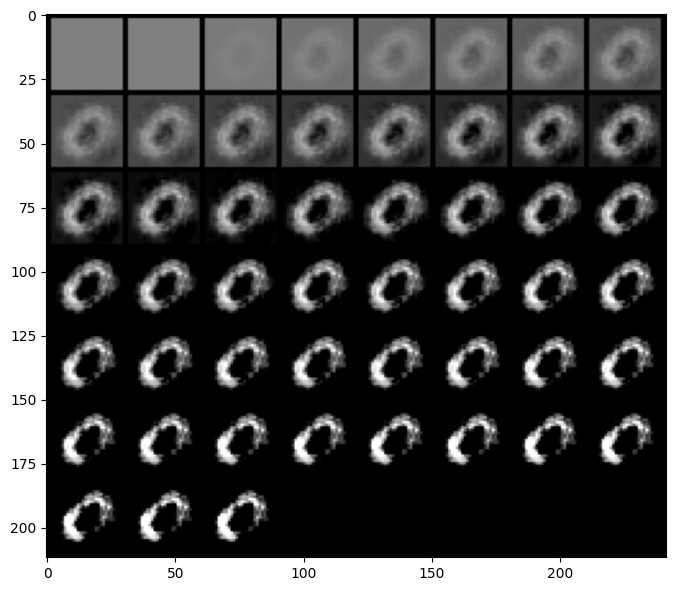

Starting 1


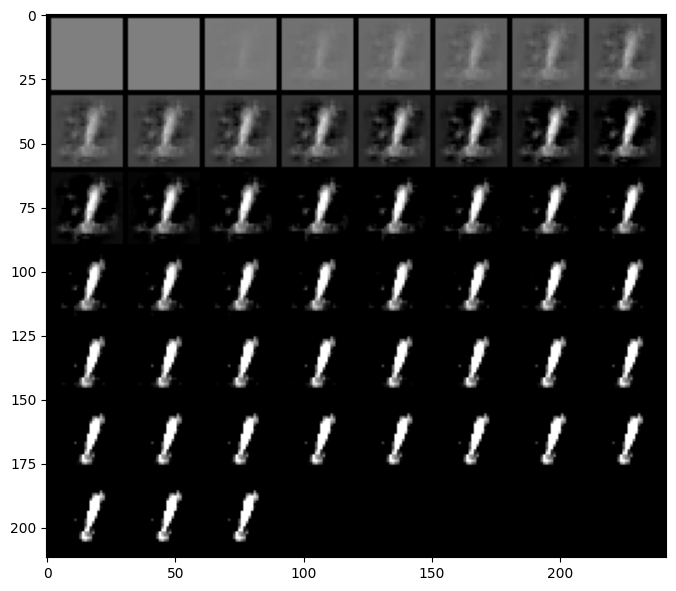

Starting 2


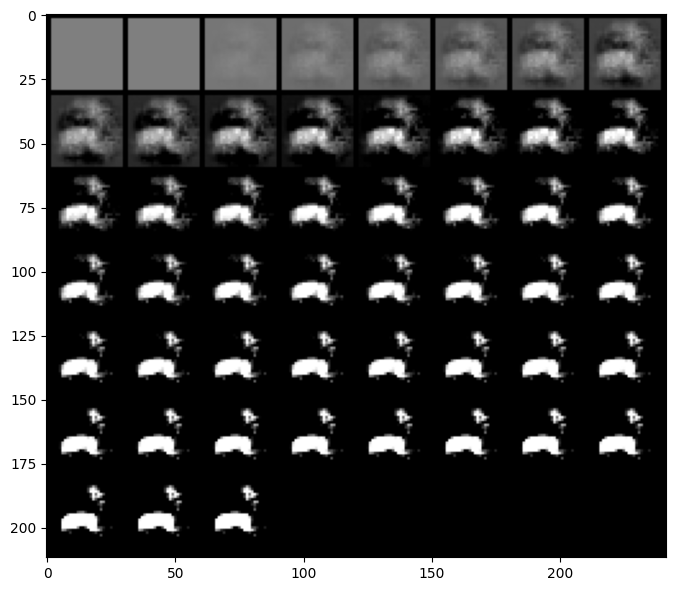

Starting 3


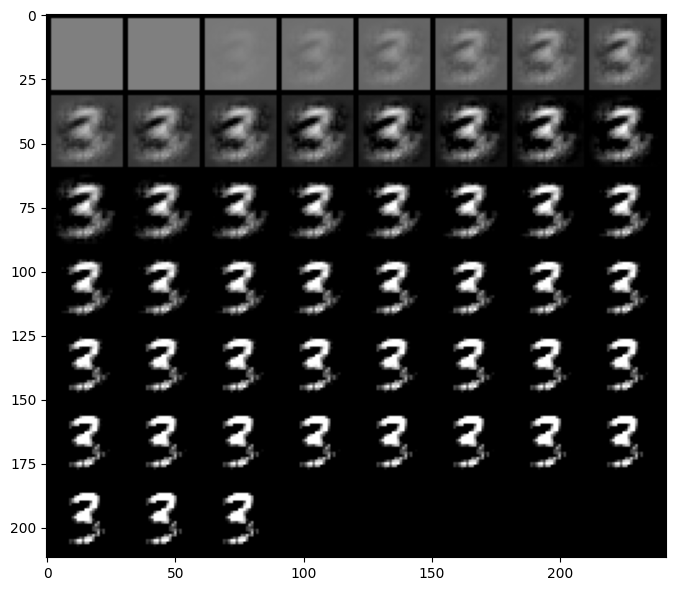

Starting 4


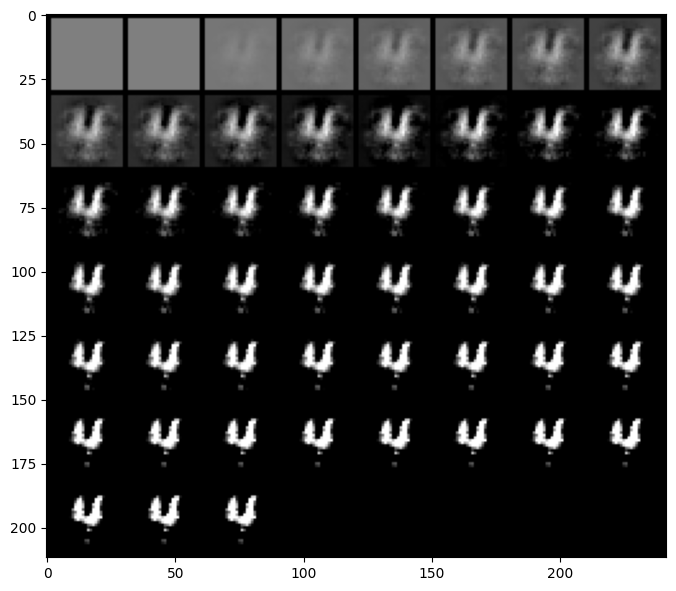

Starting 5


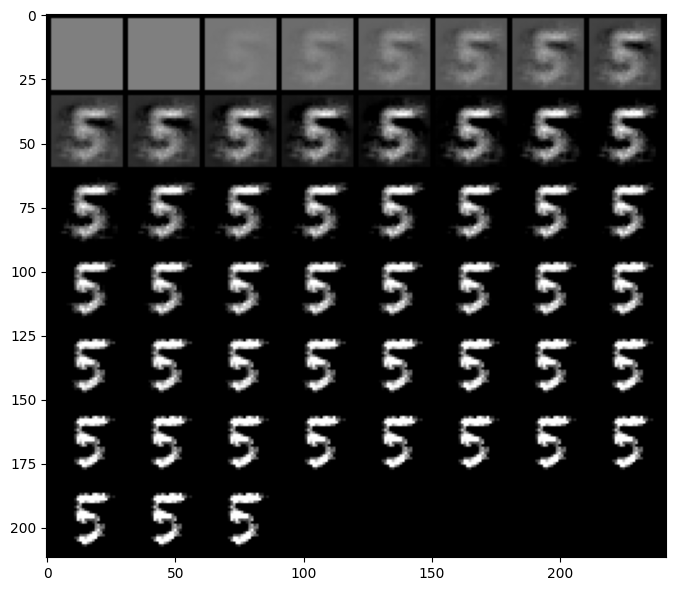

Starting 6


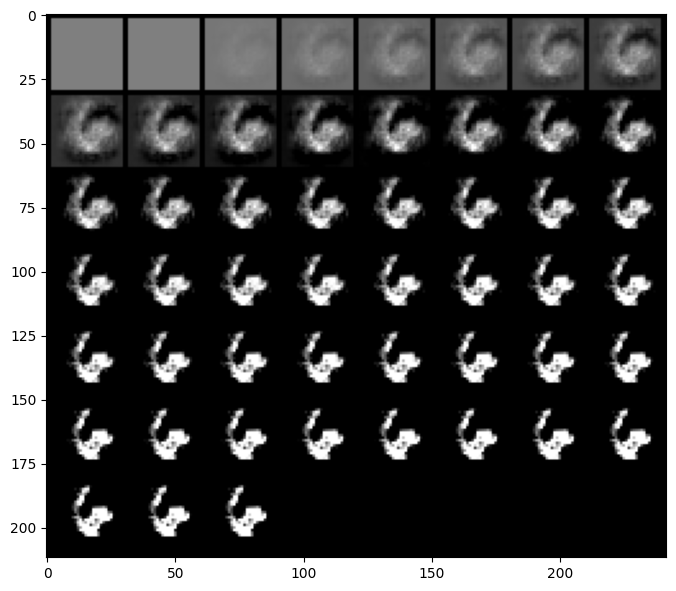

Starting 7


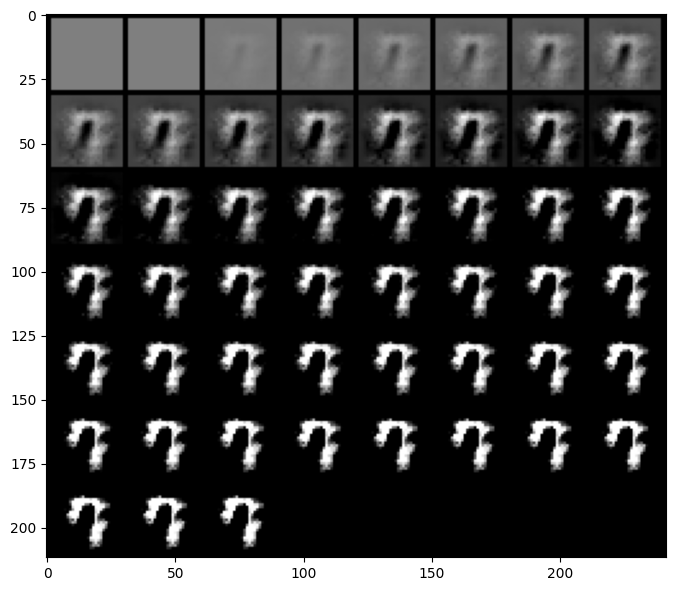

Starting 8


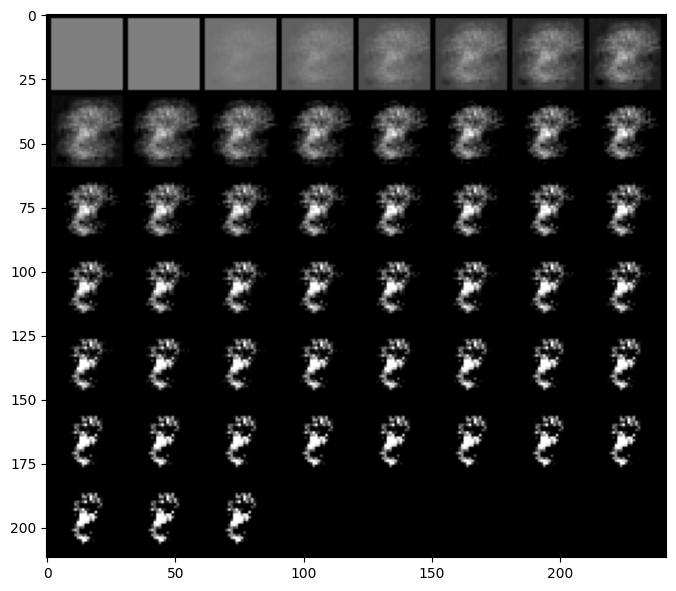

Starting 9


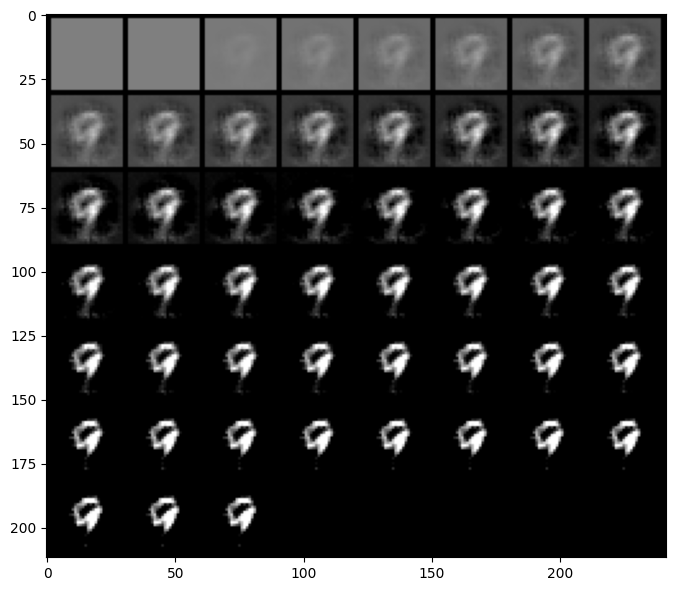

In [ ]:
from torchvision.utils import make_grid
img_start = batch[0][:1]

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
    return data_config.show(torch.tensor(np.array(x)))

# aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

quick_fwd = jax.jit(fwd_energy, static_argnames=("depth"))

# plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))
for i in range(10):
    print(f"Starting {i}")
    energies, allxs = quick_fwd(loaded_model, clamp_label=i, dt=1e-6, depth=50)
    aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])
    plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))
    plt.show()

In [ ]:
linit = jnp.zeros((10,)).at[1].set(1000.).at[0].set(1000.)
loaded_model.layers[-1].g(linit)

DeviceArray([0.48687777, 0.48687777, 0.00328056, 0.00328056, 0.00328056,
             0.00328056, 0.00328056, 0.00328056, 0.00328056, 0.00328056],            dtype=float32)

[<matplotlib.lines.Line2D>]

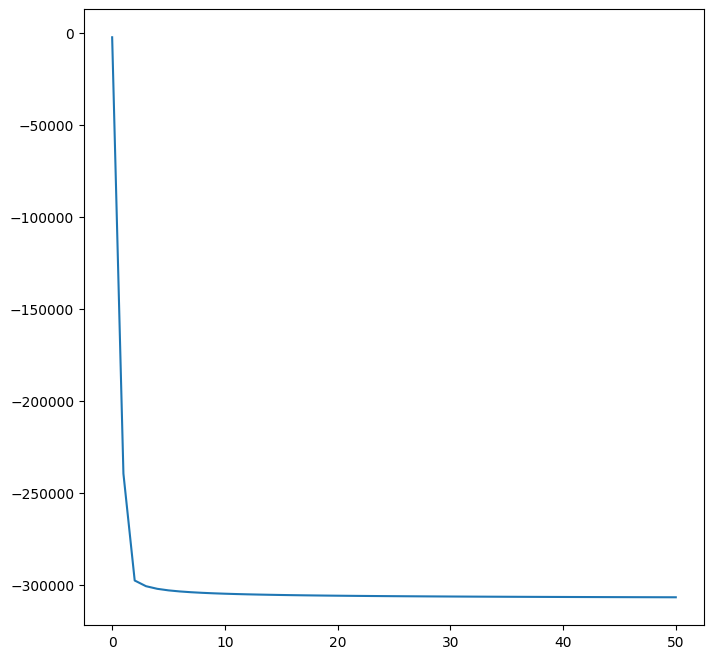

In [ ]:
plt.plot(energies)

<matplotlib.image.AxesImage>

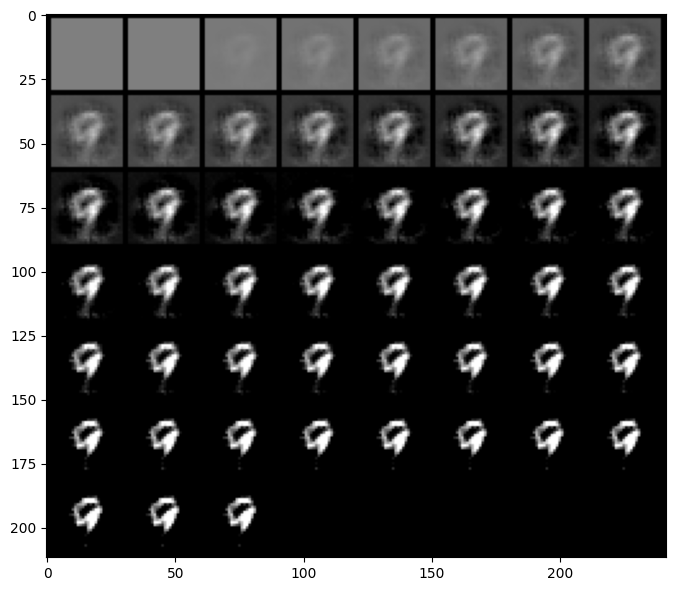

In [ ]:
from torchvision.utils import make_grid

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
    return data_config.show(torch.tensor(np.array(x)))

aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))

## TFJS

In [ ]:
import tensorflowjs as tfjs
import tensorflow as tf

2022-12-06 11:07:48.384117: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-06 11:07:49.177429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-06 11:07:49.177518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-06 11:07:49.177526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [ ]:
# This is a helper function for running inference on a TensorFlow.js model
# in Colab directly.

_TFJS_SRC_URL = 'https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@3.11.0'

# We have to make HTML resources persistent even if they are not explicitly passed
# to JavaScript. Otherwise, they will get garbage collected.
global_refs = {}

def get_tfjs_predict_fn(model_dir):
    """Load a TF SavedModel from `model_dir` and return a prediction function.

    Caling the prediction function will run inference on the TFjs model in the
    browser.

    Arg:
    model_dir: Location of the TF SavedModel.
    """
    model_path = os.path.join(model_dir, 'model.json')
    ref = google.colab.html.create_resource(filepath=model_path, route=model_path)
    weight_path = os.path.join(model_dir, 'group1-shard1of1.bin')

    def add_resource(path):
        with open(path, 'rb') as f:
            return google.colab.html.create_resource(content=f.read(), route=path)

    global global_refs
    global_refs.update({
      p: add_resource(p) for p in glob.glob(os.path.join(model_dir, '*.bin'))})

    def call_tfjs(x):
        """Calls the TFjs model in the browser and returns the output."""
        print(f'NOTE: Running TFJs inference for model in {model_dir}...')
        input_json = json.dumps(jax.tree_map(lambda x: x.tolist(), x))
        display(HTML(f'<script src="{_TFJS_SRC_URL}"></script>'))
        display(Javascript(string.Template('''
          async function getOutput() {
            const model = await tf.loadGraphModel('$model_url');
            const x = tf.tensor(JSON.parse('$inputs'));
            let result = model.predict(x);
            console.log(result.shape);
            return [await result.data(), result.shape];
          }
          window.modelOutput = getOutput();
        ''').substitute(dict(model_url=ref.url, inputs=input_json))))

        output_dict, shape = google.colab.output.eval_js('modelOutput')
        return np.array([*output_dict.values()]).reshape(shape).astype(np.float32)
    return call_tfjs

In [ ]:
def prod(params, xs):
    return params['weight'] * xs

params = {'weight': jnp.array([0.5, 1])}
xs = np.arange(6).reshape((3, 2))
jax_result = prod(params, xs)
print(jax_result)

[[0. 1.]
 [1. 3.]
 [2. 5.]]


In [ ]:
model_dir = 'tfjs'
tfjs.converters.convert_jax(
    prod,
    params,
    input_signatures=[tf.TensorSpec((3, 2), tf.float32)],
    model_dir=model_dir)

# Verify the outputs have been written.
!ls -l $model_dir

2022-12-06 11:07:49.871440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-12-06 11:07:49.871482: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-06 11:07:50.153685: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU d

Writing weight file tfjs/model.json...
total 8
-rw-r--r-- 1 bhoover30 gtperson    8 Dec  6 11:07 group1-shard1of1.bin
-rw-r--r-- 1 bhoover30 gtperson 1309 Dec  6 11:07 model.json


In [ ]:
# tfjs.converters.convert_jax(
#     prod,
#     params,
#     input_signatures=[tf.TensorSpec((3, 2), tf.float32)],
#     model_dir=model_dir)
# tfjs_predict_fn = get_tfjs_predict_fn(model_dir)
# print(tfjs_predict_fn(xs))  # Same output as JAX.


## HAMUX to TFJS

tfjs converters work by default assuming a `flax`-like API:

```
fn(params, ...) -> output
```

However, treex does not assume a `params` input. How can we port the converter to use treex?

The MNIST TFJS example uses the following flax code:

```
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x
```

In [ ]:
# 'Conv_0', 'Conv_1', 'Dense_0', 'Dense_1'

('Conv_0', 'Conv_1', 'Dense_0', 'Dense_1')

In [ ]:
# class CNN(tx.Module):
#     """A Simple CNN model"""
#     conv1: tx.Conv
#     conv2: tx.Conv
#     dense1: tx.Linear
#     dense2: tx.Linear
    
#     def __init__(self):
#         self.conv1 = tx.Conv(32, (3,3))
#         self.conv2 = tx.Conv(64, (2,2), strides=(2,2))
#         self.dense1 = tx.Linear(256)
#         self.dense2 = tx.Linear(10)
        
#     def __call__(self, x):
#         x = nn.relu(self.conv1(x))
#         x = nn.avg_pool(x, window_shape=(2,2), strides=(2,2))
#         x = nn.relu(self.conv2(x))
#         x = nn.avg_pool(x, window_shape=(2,2), strides=(2,2))
#         x = x.reshape((x.shape[0], -1))
#         x = nn.relu(self.dense1(x))
#         x = self.dense2(x)
#         return x

In [ ]:
# model = CNN().init(jax.random.PRNGKey(0), jnp.zeros((28,28,1)))

In [ ]:
model_fname = "_logs/DummyMNIST_epoch-67_acc-97.890.pckl"
loaded_model = hmx.HAM.load_ckpt(ham, model_fname)
# summarize_mnist_weights(loaded_model);

`<<<<<<< HEAD`

In [ ]:
# from jax.experimental.jax2tf.examples import jax2tfjs
import tensorflowjs as tfjs
import tensorflow as tf

def fwd_energy(model, img_pixels, labels, dt=0.4):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(1)
    # xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # Masks allow us to clamp our label data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)

    xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1050.)
    # xs[-1] = xs[-1].at[...,1].set(1000.)
    print(xs[-1])
    masks[-1] = jnp.zeros_like(masks[-1])

    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
    all_xs = [xs]
    energies = [model.venergy(xs)]

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states
        all_xs.append(xs)
        energies.append(model.venergy(xs))

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return jnp.stack(energies), all_xs

In [ ]:
tfjs_model_dir = f'tfjs_model'
tfjs.converters.convert_jax(
    fwd_energy,
    loaded_model,
    input_signatures=[tf.TensorSpec((1, 28, 28, 1), tf.float32)],
    model_dir=tfjs_model_dir,
)

`=======`

In [ ]:
# from jax.experimental.jax2tf.examples import jax2tfjs
import tensorflowjs as tfjs
import tensorflow as tf



def fwd_energy(model, img_pixels, labels, dt=0.4):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(1)
    # xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # Masks allow us to clamp our label data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)

    xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1050.)
    # xs[-1] = xs[-1].at[...,1].set(1000.)
    print(xs[-1])
    masks[-1] = jnp.zeros_like(masks[-1])

    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
    all_xs = [xs]
    energies = [model.venergy(xs)]

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states
        all_xs.append(xs)
        energies.append(model.venergy(xs))

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return jnp.stack(energies), all_xs

In [ ]:
loaded_model.sta

In [ ]:
tf.TensorSpec(

In [ ]:
tfjs_model_dir = f'tfjs_model'
tfjs.converters.convert_jax(
    fwd_energy,
    loaded_model,
    input_signatures=[tf.TensorSpec((1, 28, 28, 1), tf.float32), tf.TensorSpec((1,10), tf.float32), tf.float32],
    model_dir=tfjs_model_dir,
)

/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treeo/api.py:268: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  flat, treedef = jax.tree_flatten(obj)
/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treeo/api.py:270: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  obj = jax.tree_unflatten(treedef, flat)


ValueError: Attempt to convert a value (HAM {
    connections: list [
        list [
            list [
                0,
                1,
            ],
            0,
        ],
    ],
    layers: list [
        Layer {
            bias: None,
            lagrangian: LSphericalNorm {
                delta: 0.0,                                  float
                eps: 1e-05,
                gamma: 1.0,                                  float
                name: "lspherical_norm",                     str
            },
            name: "layer",                                   str
            shape: tuple [
                784,
            ],
            tau: 1.0,
            use_bias: False,
        },
        Layer {
            bias: None,
            lagrangian: LSoftmax {
                axis: -1,
                beta: jaxlib.DeviceArray((), float32),       Parameter
                min_beta: 1e-06,
                name: "lsoftmax",                            str
            },
            name: "layer",                                   str
            shape: tuple [
                10,
            ],
            tau: 1.0,
            use_bias: False,
        },
    ],
    name: "ham",                                             str
    synapses: list [
        HopfieldNetworkAsSynapse {
            W1: jaxlib.DeviceArray((784, 1024), float32),    Parameter
            W2: jaxlib.DeviceArray((10, 1024), float32),     Parameter
            beta: jaxlib.DeviceArray((), float32),           Parameter
            name: "hopfield_network_as_synapse",             str
            nhid: 1024,
        },
    ],
}) with an unsupported type (<class 'hamux.ham.HAM'>) to a Tensor.

`>>>>>>> dev`